In [1]:
from json import dumps, loads
from pathlib import Path

import matplotlib as plt
import missingno as msno
import numpy as np
import pandas as pd
from fuzzywuzzy import process

import re

from utils.nationality_mapper import NationalityMapper
from utils.endpoints import save_data_to_json_file, get_lat_lng

mapper = NationalityMapper()


c:\Python312\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
data_path = Path('./data/MetObject_2.json')

In [3]:
if not data_path.exists():
    save_data_to_json_file('./data/data.json')
else:
    print('Skipping data download')

Skipping data download


In [4]:
# Lectura del json
data = pd.read_json('./data/MetObject_2.json')

In [5]:
data = data.replace('', np.nan)
data = data.replace(' ', np.nan)

In [6]:
data.shape

(484956, 54)

In [7]:
data.dtypes

objectNumber             object
isHighlight               object
isTimelineWork            object
isPublicDomain            object
objectID                   int64
galleryNumber             object
department                object
accessionYear             object
objectName                object
title                     object
culture                   object
period                    object
dynasty                   object
reign                     object
portfolio                 object
constituentID             object
artistRole                object
artistPrefix              object
artistDisplayName         object
artistDisplayBio          object
artistSuffix              object
artistAlphaSort           object
artistNationality         object
artistBeginDate           object
artistEndDate             object
artistGender              object
artistUlanUrl             object
artistWikidataUrl         object
objectDate                object
objectBeginDate            int64
objectEndDa

In [8]:
data.describe()
#Dada la naturaleza de los datos esto no tiene mucho sentido y utilidad

,objectID,objectBeginDate,objectEndDate,metadataDate
count,484956.000000,484956.000000,484956.000000,0.0
mean,394499.940353,1303.913734,1402.978142,NaN
std,242732.561637,1710.259182,1132.101347,NaN
min,1.000000,-400000.000000,-240000.000000,NaN
25%,212379.750000,1535.000000,1593.000000,NaN
50%,374771.500000,1800.000000,1840.000000,NaN
75%,570971.250000,1891.000000,1905.000000,NaN
max,900748.000000,5000.000000,2870.000000,NaN


In [9]:
data.sample(2).T

,323380,283108
﻿objectNumber,1977.239ab,63.350.213.157.16
isHighlight,False,False
isTimelineWork,False,False
isPublicDomain,True,False
objectID,481659,419850
galleryNumber,556,NaN
department,Modern and Contemporary Art,Drawings and Prints
accessionYear,1977,1963
objectName,Box with lid,Photograph
title,Box with lid,From the Sunny South series (N157) for Kimball...


In [10]:
# Existencia de valores null 
data.isnull().values.any()

True

In [11]:
# Ubicación de los valores null
def get_cols_missing_val(df):
    cols_missing_val = df.columns[df.isnull().any()].tolist()
    return cols_missing_val
print(get_cols_missing_val(data))

['galleryNumber', 'accessionYear', 'objectName', 'title', 'culture', 'period', 'dynasty', 'reign', 'portfolio', 'constituentID', 'artistRole', 'artistPrefix', 'artistDisplayName', 'artistDisplayBio', 'artistSuffix', 'artistAlphaSort', 'artistNationality', 'artistBeginDate', 'artistEndDate', 'artistGender', 'artistUlanUrl', 'artistWikidataUrl', 'objectDate', 'medium', 'dimensions', 'creditLine', 'geographyType', 'city', 'state', 'county', 'country', 'region', 'subregion', 'locale', 'locus', 'excavation', 'river', 'classification', 'rightsAndReproduction', 'objectWikidataUrl', 'metadataDate', 'tags', 'tagsAatUrl', 'tagsWikiUrl']


In [12]:
# Porcentaje de valores null en cada variable
def calculate_missing_percentage(df):
    cols_missing_val_percentage = {}
    cols_missing_val = get_cols_missing_val(df)
    for col in cols_missing_val:
        percentage = (df[col].isnull().sum())
        dimension = len(df)
        final_percentage = round((percentage/dimension)*100,4)
        cols_missing_val_percentage[col] = final_percentage
    return  cols_missing_val_percentage        

In [13]:
print(calculate_missing_percentage(data))

{'galleryNumber': 89.7844, 'accessionYear': 0.7964, 'objectName': 0.4673, 'title': 5.9106, 'culture': 57.0703, 'period': 81.2059, 'dynasty': 95.2159, 'reign': 97.6831, 'portfolio': 94.5327, 'constituentID': 41.7446, 'artistRole': 41.7446, 'artistPrefix': 71.989, 'artistDisplayName': 41.7446, 'artistDisplayBio': 49.4272, 'artistSuffix': 78.988, 'artistAlphaSort': 41.7607, 'artistNationality': 47.1082, 'artistBeginDate': 41.7446, 'artistEndDate': 41.7446, 'artistGender': 78.043, 'artistUlanUrl': 53.1007, 'artistWikidataUrl': 53.7686, 'objectDate': 2.7695, 'medium': 1.4876, 'dimensions': 15.4771, 'creditLine': 0.1342, 'geographyType': 87.6362, 'city': 93.246, 'state': 99.4595, 'county': 98.2351, 'country': 84.327, 'region': 93.5046, 'subregion': 95.434, 'locale': 96.7546, 'locus': 98.4498, 'excavation': 96.583, 'river': 99.5686, 'classification': 16.2318, 'rightsAndReproduction': 94.942, 'objectWikidataUrl': 85.7401, 'metadataDate': 100.0, 'tags': 60.315, 'tagsAatUrl': 60.4129, 'tagsWikiU

In [14]:
data['country'].fillna('Unknown', inplace = True)
data['artistDisplayName'].fillna('Anonymous', inplace = True)

In [15]:
# Debido a que hay una gran cantidad de columnas que se encuentran predominantemente vacías, se decide que aquellas cuyo porcentaje de nulidad
# exceda al 60%, se eliminarán del estudio. Esto a excepción de la columna de país, ya que esta se imputará más tarde con la nacionalidad del artista
cols_missing_val_percentage = calculate_missing_percentage(data)
for col, percentage in cols_missing_val_percentage.items():
    if percentage >= 60:
        data = data.drop(col, axis=1)

In [16]:
# Se reduce la dimensionalidad del dataset eliminando las columnas innecesarias para el objeto de este proyecto 

filtered_columns = ['objectID', 'isHighlight', 'accessionYear', 'isPublicDomain', 'department', 'objectName', 'title', 'country',
                    'artistDisplayName', 'artistNationality', 'objectBeginDate', 'objectEndDate', 'culture', 'classification', 'linkResource']

filtered_data = data[filtered_columns]

Imputación de valores faltantes 

In [17]:
# Dado que accessionYear tiene menos de 1% de missing values, se opta por eliminar los registros que no tienen la fecha de adquisión de la obra
# por parte del MET 

filtered_data.dropna(subset = ['accessionYear'], inplace = True)

C:\Users\nikky\AppData\Local\Temp\ipykernel_43484\698884717.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset = ['accessionYear'], inplace = True)


In [18]:
# Se analiza la correlación de las demás variables con valores nulos 

cols_missing_val = filtered_data.columns[filtered_data.isnull().any()].tolist()
df_missing_data = filtered_data[cols_missing_val].copy()
df_missing_data.isnull().corr()

,objectName,title,artistNationality,culture,classification
objectName,1.000000,-0.006836,-0.015560,0.040939,-0.016189
title,-0.006836,1.000000,0.185855,-0.288463,-0.109700
artistNationality,-0.015560,0.185855,1.000000,-0.508066,0.157922
culture,0.040939,-0.288463,-0.508066,1.000000,-0.167600
classification,-0.016189,-0.109700,0.157922,-0.167600,1.000000


<Axes: >

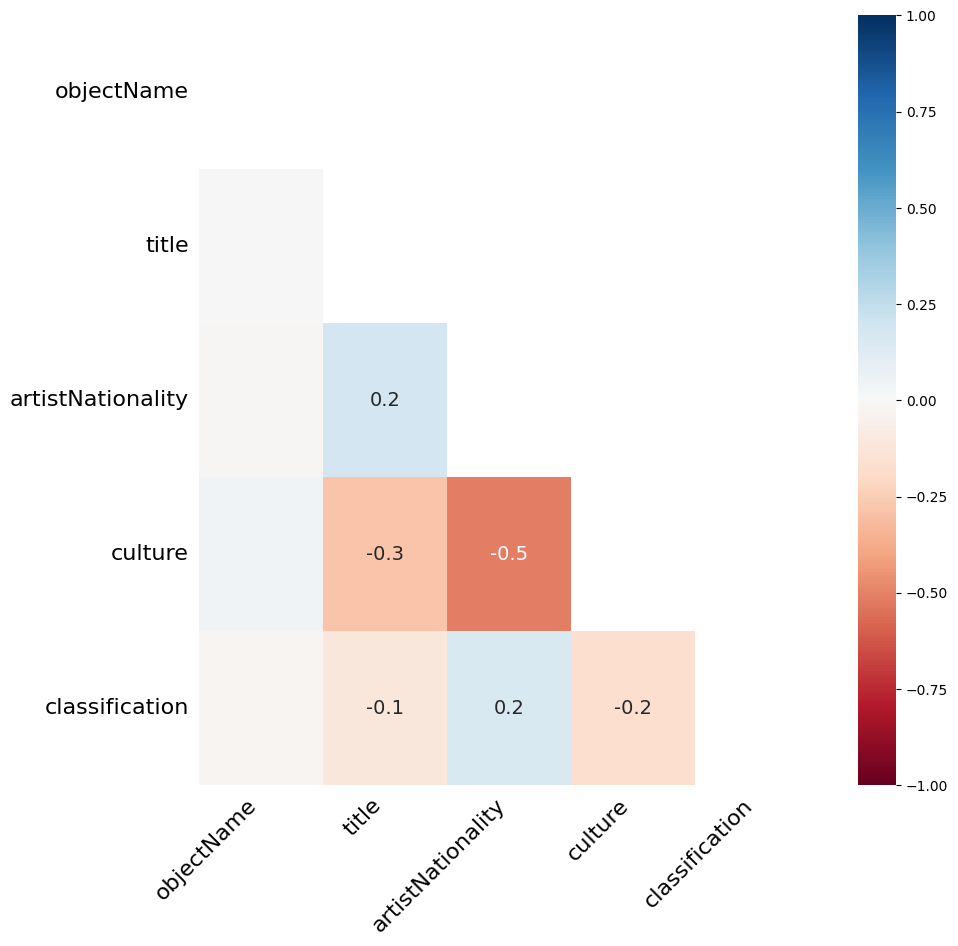

In [19]:
# Lo anterior, representado visualmente sería: 
msno.heatmap(filtered_data[cols_missing_val],figsize=(10,10))

<Axes: >

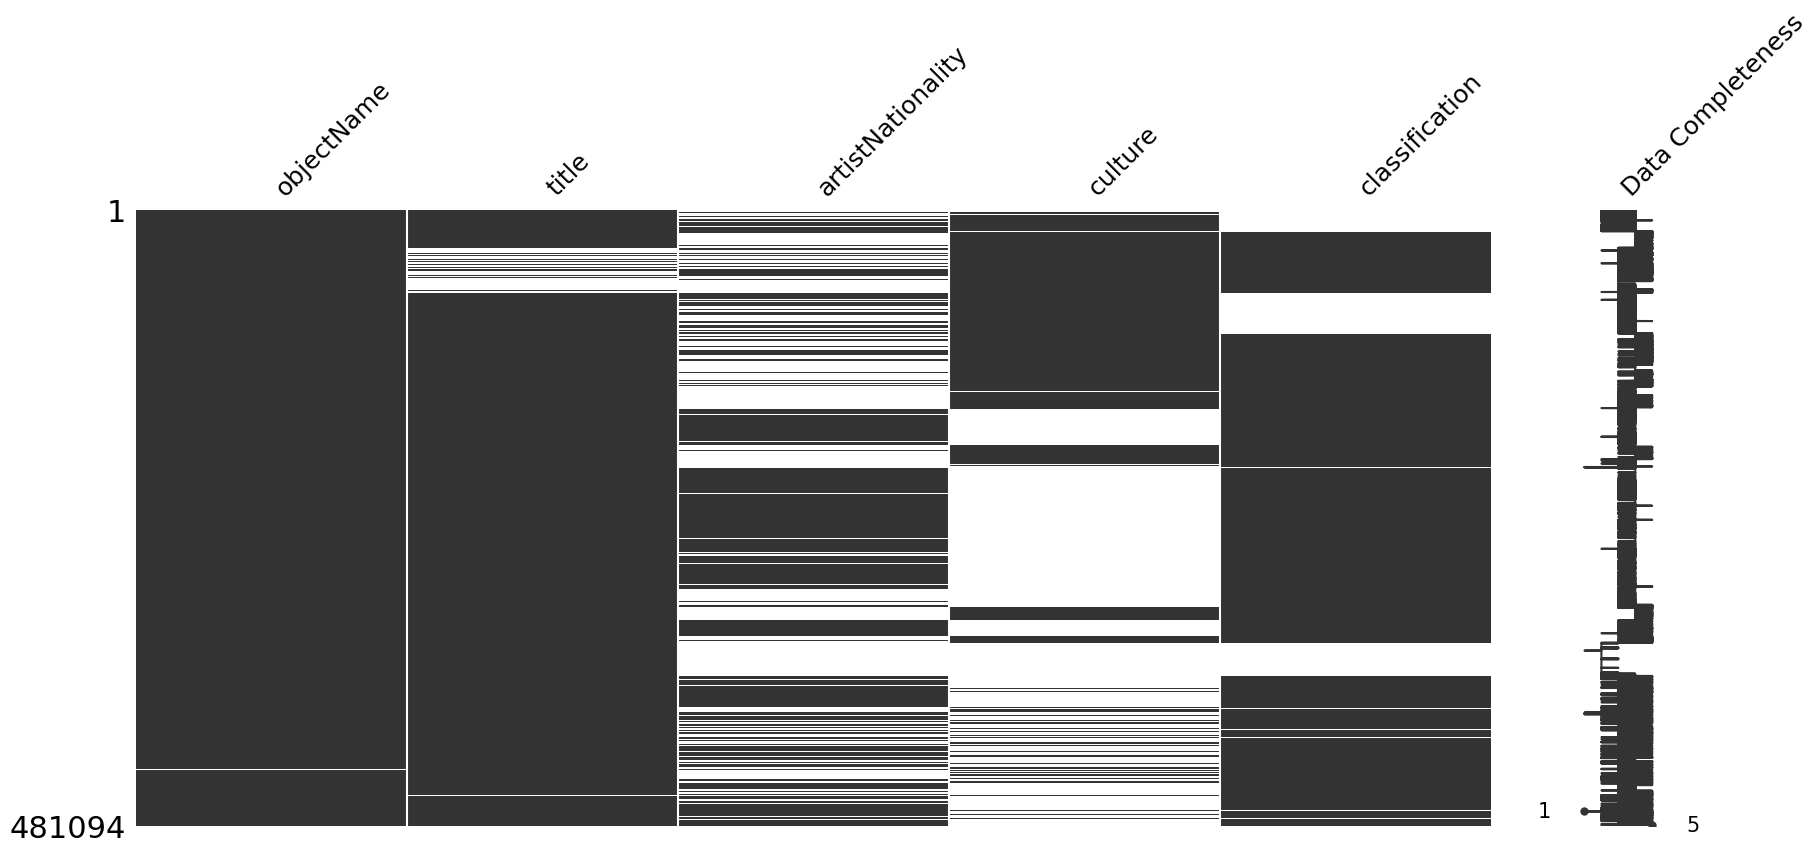

In [20]:
msno.matrix(filtered_data[cols_missing_val],width_ratios=(10,1),\
            figsize=(20,8),color=(0.2,0.2,0.2),fontsize=18,sparkline=True,labels=True)

In [21]:
# Es muy común que existan obras de artistas desconocidos. Además, teniendo en cuenta la correlacion perfecta (1)
# entre las variables artistDisplayName y artistNationality se opta por imputar los valores nulos de ambas columnas con el 
# string 'Unknown'.
# La afirmación anterior es válida para las demás columnas: objectName, title, culture y classification. 
for col in cols_missing_val:
    filtered_data[col].fillna('Unknown', inplace = True)

C:\Users\nikky\AppData\Local\Temp\ipykernel_43484\3109365828.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col].fillna('Unknown', inplace = True)


In [22]:
df = filtered_data.copy()
# Define a mapping dictionary
mapping = {'True': True, 'False': False}

# Map the values in the 'column' using the mapping dictionary
df['isHighlight'] = df['isHighlight'].map(mapping)
df['isPublicDomain'] = df['isPublicDomain'].map(mapping)
df = df.astype({'department': 'string', 'title': 'string', 'objectName': 'string', 'artistDisplayName': 'string', 'artistNationality': 'string', 'culture': 'string', 'classification': 'string', 'linkResource': 'string'})

In [23]:
# Function to extract the first nationality for each artist
def extract_first_nationality(artist_nationalities):
    artist_nationalities_list = artist_nationalities.split("\|")
    first_nationalities = []
    for nationality in artist_nationalities_list:
        first_nationality = nationality.replace(",", " ").split(" ")[0].strip()
        first_nationalities.append(first_nationality)
    return "|".join(first_nationalities)


<>:3: SyntaxWarning: invalid escape sequence '\|'
<>:3: SyntaxWarning: invalid escape sequence '\|'
C:\Users\nikky\AppData\Local\Temp\ipykernel_43484\3805233418.py:3: SyntaxWarning: invalid escape sequence '\|'
  artist_nationalities_list = artist_nationalities.split("\|")


In [24]:
# Function to map nationality to country using the mapper
def map_to_country(nationality):
    return mapper.get_country_by_nationality(nationality)

In [25]:

# Apply the extraction function to the artistNationality column
df['first_nationalities'] = df['artistNationality'].apply(extract_first_nationality)

# Apply the mapping function to each nationality in the list to get the country
df['artistCountry'] = df['first_nationalities'].apply(lambda x: "|".join(map(map_to_country, x.split("|"))))

In [26]:
def determine_prevalent_country(country_counts):
    max_count = max(country_counts.values())
    max_countries = [country for country, count in country_counts.items() if count == max_count]
    if len(max_countries) == 1:
        return max_countries[0]
    elif len(max_countries) > 1:
        return 'Other'
    else:
        return None

In [27]:
# Function to preprocess artistCountry and count occurrences of each country
def preprocess_and_count_countries(countries_str):
    countries = countries_str.split('|')
    country_counts = {}
    for country in countries:
        if country != 'Unknown':
            if country in country_counts:
                country_counts[country] += 1
            else:
                country_counts[country] = 1
    return country_counts

In [28]:
# Function to update artistCountry based on the prevalent country
def update_artist_country(row):
    country_counts = preprocess_and_count_countries(row['artistCountry'])
    
    if not country_counts:
        return 'Unknown'
    
    if len(country_counts) == 1:
        return list(country_counts.keys())[0]
    else:
        prevalent_country = determine_prevalent_country(country_counts)
        return prevalent_country

In [29]:
def update_country(row):
    country_counts = preprocess_and_count_countries(row['country'])
    
    if not country_counts:
        return 'Unknown'
    
    if len(country_counts) == 1:
        return list(country_counts.keys())[0]
    else:
        prevalent_country = determine_prevalent_country(country_counts)
        return prevalent_country

In [30]:
# Apply the function to each row of the DataFrame
df['artistCountry'] = df.apply(update_artist_country, axis=1)
df['country'] = df['country'].mask(df['country'] == 'Unknown', df['artistCountry'])
# Drop column: 'first_nationalities'
df = df.drop(columns=['first_nationalities', 'artistCountry'])

In [31]:
country_values = df['country'].unique().tolist()

In [32]:
def get_inconsistent_countries(country_values):
    # Regular expression pattern to match non-standard delimiters
    non_standard_delimiters_pattern = r'[;:]'

    # List of ambiguous descriptions
    ambiguous_descriptions = ['possibly', 'probably', 'etc']

    # Constructing the regular expression pattern to match entire words
    ambiguous_words_pattern = r'\b(?:' + '|'.join(ambiguous_descriptions) + r')\b'

    # List to store inconsistencies
    inconsistencies = []

    for value in country_values:
        # Check for non-standard delimiters
        if re.search(non_standard_delimiters_pattern, value):
            inconsistencies.append(value)
        # Check for ambiguous descriptions
        elif re.search(ambiguous_words_pattern, value.lower()):
            inconsistencies.append(value)
    return inconsistencies


In [33]:
inconsistent_values = get_inconsistent_countries(country_values)

In [34]:
def find_closest_match(value, known_values):
    match, score = process.extractOne(value, known_values)
    if score >= 90:  # Adjust the threshold as needed
        return match
    else:
        return None

In [35]:
# Function to standardize values using known mappings
def standardize_value(value, known_mappings):
    for standard_value, synonyms in known_mappings.items():
        if value in synonyms:
            return standard_value
    closest_match = find_closest_match(value, known_mappings.keys())
    if closest_match:
        return closest_match
    return value  # Return the original value if no match is found

In [39]:
# Get the known mappings from the Mapper instance
known_mappings = mapper.get_known_mappings()

# Standardize inconsistent values
standardized_values = [standardize_value(value, known_mappings) for value in inconsistent_values]
standardized_values = [standardize_value(value, known_mappings) for value in standardized_values]

In [37]:
filtered_df = df[df['country'].isin(inconsistent_values)]

In [38]:
# Standardize inconsistent values in the 'country' column
filtered_df['country'] = filtered_df['country'].apply(lambda x: standardize_value(x, known_mappings))

C:\Users\nikky\AppData\Local\Temp\ipykernel_43484\4093991077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['country'] = filtered_df['country'].apply(lambda x: standardize_value(x, known_mappings))


In [39]:
df.to_csv('./data/cleaned_data.csv')